In [1]:
from autobounds.causalProblem import causalProblem
from autobounds.DAG import DAG

from causalgraphicalmodels import StructuralCausalModel
import numpy as np
import pandas as pd


In [2]:
scm = StructuralCausalModel({
    # Unobserved variables affecting more than one variable
    "U1": lambda n_samples: np.random.binomial(1, 0.45, size=n_samples),
    "U2": lambda n_samples: np.random.binomial(1, 0.4103, size=n_samples),

    # Unobserved variables affecting only one variable (noise variables)
    "N1": lambda n_samples: np.random.binomial(1, 0.09, size=n_samples),
    "N2": lambda n_samples: np.random.binomial(1, 0.59, size=n_samples),
    "N3": lambda n_samples: np.random.binomial(1, 0.72, size=n_samples),

    #todo figure out what exactly .all() does
    # Observed variables and their respective functions
    "X1": lambda N1, U1, U2, n_samples:  U1 | N1 if U2.all() == 0 else (U2 ^ 1) & N1,
    "X2": lambda N2, X1, U2, n_samples: X1 * U2 ^ N2,
    "Y": lambda N3, U1, X2, n_samples: X2 | U1 if X2.all() == 1 else X2 ^ N3,

})

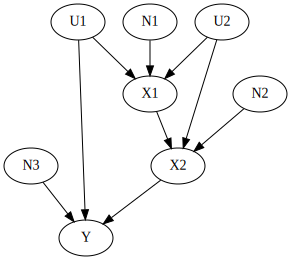

In [3]:
ds = scm.sample(100000)
ds.to_csv("non-id_data.csv",
          index=False)
scm.cgm.draw()

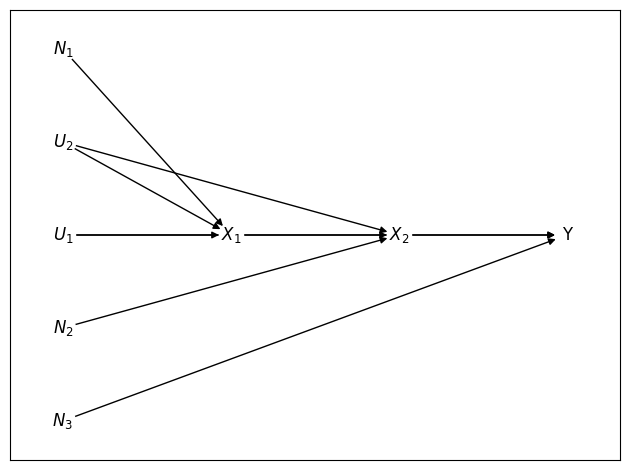

In [4]:
dag = DAG()
dag.from_structure(edges=
                         "U1 -> X1, U1 -> Y,"
                         "U2 -> X1, U2 -> X2,"
                         "N1 -> X1, X1 -> X2,"
                         "N2 -> X2, X2 -> Y,"
                         "N3 -> Y",
                   unob="U1, U2, N1, N2, N3", )

dag.plot()
raw_data = pd.read_csv("non-id_data.csv")
# raw_data.info()

In [5]:
# group individuals into strata
data = raw_data.loc[:, ['X1', 'X2', 'Y']]
data = pd.DataFrame(data.groupby(['X1', 'X2', 'Y']).value_counts().reset_index())
data['prob'] = data['count'] / data['count'].sum()
dat = data.drop(columns='count', axis=0)
dat

,X1,X2,Y,prob
0,0,0,0,0.05658
1,0,0,1,0.14793
2,0,1,0,0.21388
3,0,1,1,0.08278
4,1,0,0,0.06699
5,1,0,1,0.17526
6,1,1,0,0.18549
7,1,1,1,0.07109


In [6]:
problem = causalProblem(dag)

problem.load_data(dat)
problem.add_prob_constraints()

In [7]:
problem.set_ate(ind="X2", dep="Y")
prog_ate = problem.write_program()


In [8]:
# run optimisation routine, argument saves results at filename
prog_ate_optim = prog_ate.run_scip('results/non-id_data.csv')

print("==============================================")
print(f"Causal effect lies in the interval [{np.round(prog_ate_optim[0]['dual'], 3)}, "
      f"{np.round(prog_ate_optim[1]['dual'], 3)}]"
      )

Problem is finished! Returning final values
Problem is finished! Returning final values
Causal effect lies in the interval [-0.723, 0.277]
